Main Part and Bonus Part:

Compare different dimension of latent space:

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [13]:
batch_size = 128
latent_dims = [2, 4, 16]  
epochs = 60

In [14]:
# Data Preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,))
])

train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
# Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

In [16]:
# Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 400)
        self.fc2 = nn.Linear(400, output_dim)

    def forward(self, z):
        h = torch.relu(self.fc1(z))
        x_recon = torch.sigmoid(self.fc2(h))
        return x_recon.view(-1, 1, 28, 28)

In [17]:
# Variational Autoencoder (VAE)
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(28 * 28, latent_dim)
        self.decoder = Decoder(latent_dim, 28 * 28)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

In [18]:
# Loss Function
def loss_function(x_recon, x, mu, logvar):
    recon_loss = nn.functional.binary_cross_entropy(x_recon, x, reduction="sum")
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

In [19]:
# Training Function
def train(model, train_loader, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for x, _ in train_loader:
            optimizer.zero_grad()
            x_recon, mu, logvar = model(x)
            loss = loss_function(x_recon, x, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f"Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset):.4f}")

In [20]:
from skimage.metrics import peak_signal_noise_ratio as psnr

def test(model, test_loader):
    model.eval()
    correct_pixels = 0
    total_pixels = 0
    z_points = []
    labels = []
    psnr_values = []

    with torch.no_grad():
        for x, y in test_loader:
            x_recon, mu, logvar = model(x)
            x_binary = (x > 0.5).float()
            x_recon_binary = (x_recon > 0.5).float()
            correct_pixels += (x_binary == x_recon_binary).sum().item()
            total_pixels += x_binary.numel()

            # Calculate PSNR for each image
            x = x.view(x.size(0), -1).cpu().numpy()
            x_recon = x_recon.view(x_recon.size(0), -1).cpu().numpy()
            for i in range(x.shape[0]):
                psnr_values.append(psnr(x[i], x_recon[i], data_range=1.0))

            z_points.append(mu.cpu().numpy())
            labels.append(y.cpu().numpy())

    accuracy = 100 * correct_pixels / total_pixels
    z_points = np.concatenate(z_points)
    labels = np.concatenate(labels)
    avg_psnr = np.mean(psnr_values)
    return accuracy, avg_psnr, z_points, labels


In [21]:
# Visualization Function
def visualize_latent_space(z_points, labels, latent_dim):
    if latent_dim > 2:
        z_points = TSNE(n_components=2).fit_transform(z_points)
    plt.figure(figsize=(8, 6))
    plt.scatter(z_points[:, 0], z_points[:, 1], c=labels, cmap="tab10", s=5)
    plt.colorbar()
    plt.title(f"Latent Space (dim={latent_dim})")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.show()

# Reconstruction Visualization
def visualize_reconstruction(model, test_loader):
    model.eval()
    with torch.no_grad():
        for x, _ in test_loader:
            x_recon, _, _ = model(x)
            break

    fig, axes = plt.subplots(2, 10, figsize=(15, 4))
    for i in range(10):
        axes[0, i].imshow(x[i].squeeze(), cmap="gray")
        axes[0, i].axis("off")
        axes[1, i].imshow(x_recon[i].squeeze(), cmap="gray")
        axes[1, i].axis("off")
    axes[0, 0].set_title("Original")
    axes[1, 0].set_title("Reconstructed")
    plt.show()


Training VAE with latent_dim=2
Epoch 1, Loss: 190.2590
Epoch 2, Loss: 166.7270
Epoch 3, Loss: 162.9287
Epoch 4, Loss: 160.5815
Epoch 5, Loss: 159.1150
Epoch 6, Loss: 158.0067
Epoch 7, Loss: 157.0646
Epoch 8, Loss: 156.3078
Epoch 9, Loss: 155.5677
Epoch 10, Loss: 154.8978
Epoch 11, Loss: 154.2874
Epoch 12, Loss: 153.7128
Epoch 13, Loss: 153.2588
Epoch 14, Loss: 152.7480
Epoch 15, Loss: 152.2933
Epoch 16, Loss: 151.7640
Epoch 17, Loss: 151.2664
Epoch 18, Loss: 150.8793
Epoch 19, Loss: 150.5058
Epoch 20, Loss: 150.2006
Epoch 21, Loss: 149.9108
Epoch 22, Loss: 149.6484
Epoch 23, Loss: 149.3735
Epoch 24, Loss: 149.1541
Epoch 25, Loss: 148.9445
Epoch 26, Loss: 148.6896
Epoch 27, Loss: 148.4545
Epoch 28, Loss: 148.2833
Epoch 29, Loss: 148.1221
Epoch 30, Loss: 147.9105
Epoch 31, Loss: 147.7674
Epoch 32, Loss: 147.5697
Epoch 33, Loss: 147.3986
Epoch 34, Loss: 147.3218
Epoch 35, Loss: 147.0698
Epoch 36, Loss: 147.0042
Epoch 37, Loss: 146.8711
Epoch 38, Loss: 146.7344
Epoch 39, Loss: 146.5963
Epo

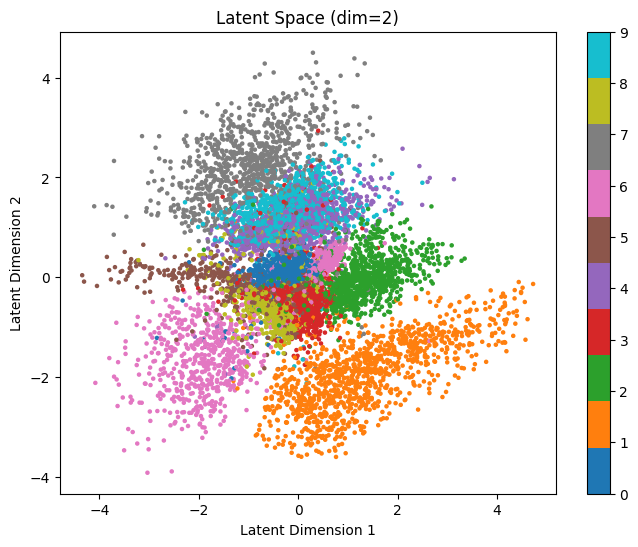

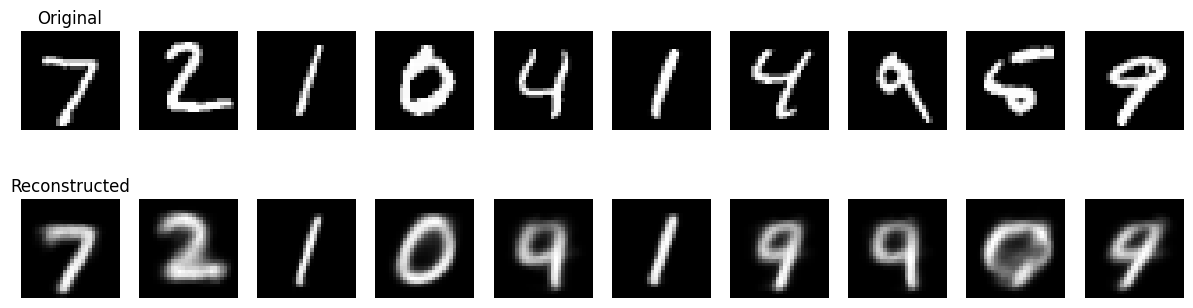

Training VAE with latent_dim=4
Epoch 1, Loss: 173.0536
Epoch 2, Loss: 145.9816
Epoch 3, Loss: 141.8916
Epoch 4, Loss: 139.4238
Epoch 5, Loss: 137.7020
Epoch 6, Loss: 136.4403
Epoch 7, Loss: 135.3981
Epoch 8, Loss: 134.6035
Epoch 9, Loss: 133.8526
Epoch 10, Loss: 133.1597
Epoch 11, Loss: 132.5726
Epoch 12, Loss: 132.0818
Epoch 13, Loss: 131.6215
Epoch 14, Loss: 131.1500
Epoch 15, Loss: 130.7800
Epoch 16, Loss: 130.4316
Epoch 17, Loss: 130.0523
Epoch 18, Loss: 129.7651
Epoch 19, Loss: 129.5065
Epoch 20, Loss: 129.2054
Epoch 21, Loss: 128.9465
Epoch 22, Loss: 128.7172
Epoch 23, Loss: 128.4977
Epoch 24, Loss: 128.2417
Epoch 25, Loss: 128.0521
Epoch 26, Loss: 127.8486
Epoch 27, Loss: 127.6600
Epoch 28, Loss: 127.5149
Epoch 29, Loss: 127.3247
Epoch 30, Loss: 127.2253
Epoch 31, Loss: 127.0409
Epoch 32, Loss: 126.8881
Epoch 33, Loss: 126.7472
Epoch 34, Loss: 126.6320
Epoch 35, Loss: 126.5321
Epoch 36, Loss: 126.3989
Epoch 37, Loss: 126.2627
Epoch 38, Loss: 126.1692
Epoch 39, Loss: 126.0616
Epo

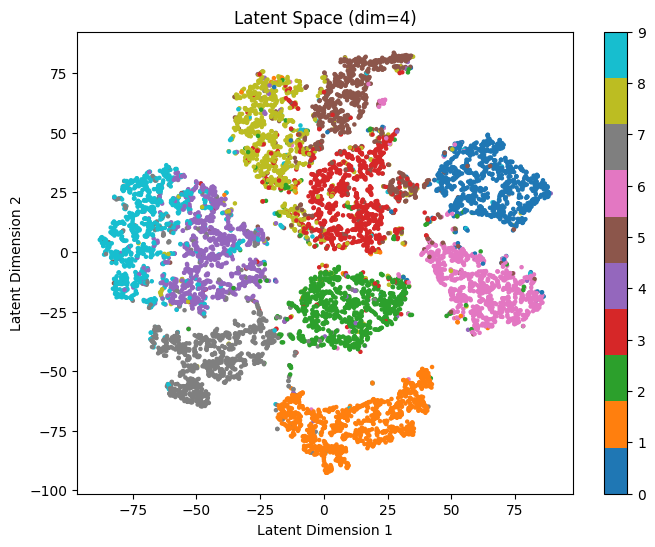

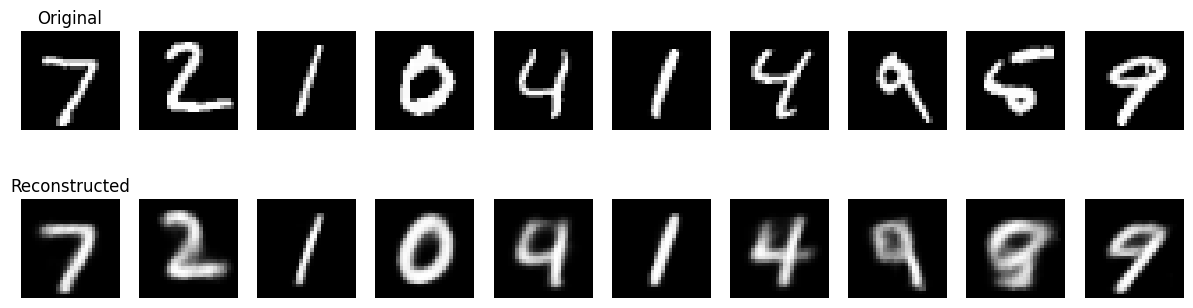

Training VAE with latent_dim=16
Epoch 1, Loss: 163.5568
Epoch 2, Loss: 121.3815
Epoch 3, Loss: 115.2029
Epoch 4, Loss: 112.3437
Epoch 5, Loss: 110.6425
Epoch 6, Loss: 109.4944
Epoch 7, Loss: 108.6281
Epoch 8, Loss: 107.9175
Epoch 9, Loss: 107.3765
Epoch 10, Loss: 106.9519
Epoch 11, Loss: 106.5573
Epoch 12, Loss: 106.2339
Epoch 13, Loss: 105.9278
Epoch 14, Loss: 105.6486
Epoch 15, Loss: 105.3930
Epoch 16, Loss: 105.1630
Epoch 17, Loss: 104.9974
Epoch 18, Loss: 104.7910
Epoch 19, Loss: 104.5640
Epoch 20, Loss: 104.3947
Epoch 21, Loss: 104.2818
Epoch 22, Loss: 104.1236
Epoch 23, Loss: 103.9881
Epoch 24, Loss: 103.8362
Epoch 25, Loss: 103.7429
Epoch 26, Loss: 103.6382
Epoch 27, Loss: 103.5409
Epoch 28, Loss: 103.4153
Epoch 29, Loss: 103.3117
Epoch 30, Loss: 103.2068
Epoch 31, Loss: 103.1175
Epoch 32, Loss: 103.0230
Epoch 33, Loss: 102.9143
Epoch 34, Loss: 102.8615
Epoch 35, Loss: 102.7619
Epoch 36, Loss: 102.7048
Epoch 37, Loss: 102.5874
Epoch 38, Loss: 102.5666
Epoch 39, Loss: 102.5204
Ep

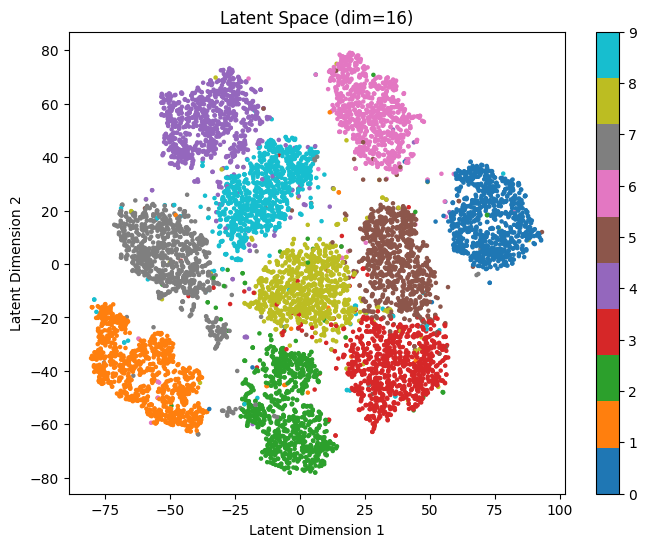

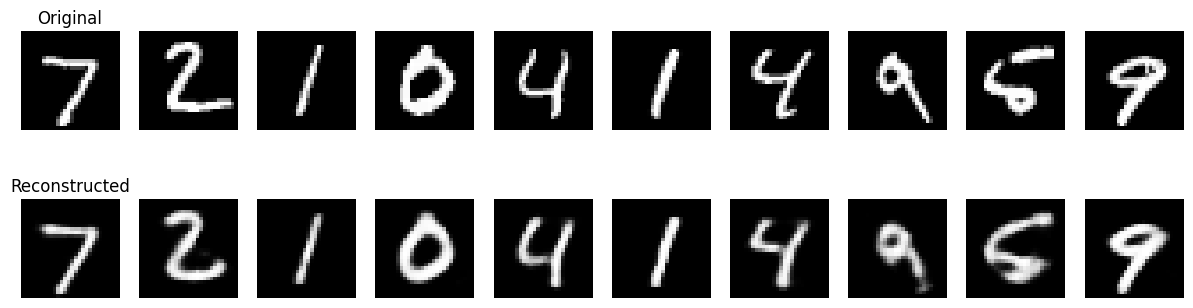

In [22]:
for latent_dim in latent_dims:
    print(f"Training VAE with latent_dim={latent_dim}")
    model = VAE(latent_dim)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    train(model, train_loader, optimizer, epochs)

    print(f"Evaluating VAE with latent_dim={latent_dim}")
    accuracy, avg_psnr, z_points, labels = test(model, test_loader)
    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Average PSNR: {avg_psnr:.2f} dB")

    visualize_latent_space(z_points, labels, latent_dim)
    visualize_reconstruction(model, test_loader)